In [7]:
import sys

import seaborn
from tensorflow.keras import datasets, layers, models, losses
import numpy as np
from PIL import Image
import tensorflow as tf
import torchvision as tv
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras
import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix

sys.path.append('../../')

from core.datasets import get_ds, open_f
from core.make_answer import make_ans_file 
from core.ensembles import get_bagging_pred, print_bagging_ensemble_statistic, print_models_statistic, get_ensemble_modelbase, get_modeset


In [8]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-10, 10), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
])

In [9]:
acc_test_ds = open_f("smote_data_train_5000", back=2)

In [10]:
acc_test_ds_y = acc_test_ds["labels"]
acc_test_ds_x = acc_test_ds["images"] / 255.

In [11]:
train_ds, val_ds, test_ds = get_ds('repaired_data_train', 'repaired_data_test', transform=transformer, one_hot=True, back=2)
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.argmax(val_ds_y, axis=1)

In [12]:
model_1 = tf.keras.models.load_model(f'../checkpoints/model_g_1_categorical_accuracy.h5')
model_3 = tf.keras.models.load_model(f'../checkpoints/model_g_3_categorical_accuracy.h5')
model_smote = tf.keras.models.load_model(f'../checkpoints/model_s_smote_categorical_accuracy.h5')
model_c = tf.keras.models.load_model(f'../checkpoints/model_C_EN_1_categorical_accuracy.h5')
model_8 = tf.keras.models.load_model(f'../checkpoints/model_g_8_categorical_accuracy.h5')
model_36h_griganet = tf.keras.models.load_model(f'../checkpoints/model_g_11_categorical_accuracy.h5')
model_16 = tf.keras.models.load_model(f'../checkpoints/model_g_16_avg_categorical_accuracy.h5')
model_17 = tf.keras.models.load_model(f'../checkpoints/model_g_17_categorical_accuracy.h5')

In [14]:
models = [model_1, model_smote, model_8, model_c, model_36h_griganet, model_16, model_17]
names = ["model G1", "model SMOTE", "model G8", "model C1", "model G11", "model G16", "model G17"]

modelbase = get_ensemble_modelbase(models=models, names=names, x_val=acc_test_ds_x)

In [15]:
print_models_statistic(modelbase=modelbase, y_val=acc_test_ds_y)

SCORE
model G1: accuracy: 0.97812 f1_score: 0.9781390642763794
model SMOTE: accuracy: 0.99148 f1_score: 0.9914831152938497
model G8: accuracy: 0.98592 f1_score: 0.9859201269079992
model C1: accuracy: 0.9719 f1_score: 0.9719381931043831
model G11: accuracy: 0.98904 f1_score: 0.9890429354052381
model G16: accuracy: 0.94302 f1_score: 0.9430040339635017
model G17: accuracy: 0.98858 f1_score: 0.9885811520847717


In [34]:
selected_names = ["model SMOTE", "model G8", "model C1", "model G11", "model G17"]
modelset = get_modeset(modelbase, selected_names)

было замечено что повышение итогового accuracy на пару тысячных может на кегли может увеличить результат на пару сотых. Так что не стоит делать выводы только по accuracy. 

In [35]:
y_test_acc_pred = print_bagging_ensemble_statistic(modelset=modelset, y_val=acc_test_ds_y)

SCORE

ensemble accuracy: 0.9967

ensemble f1_score: 0.9966997710651752


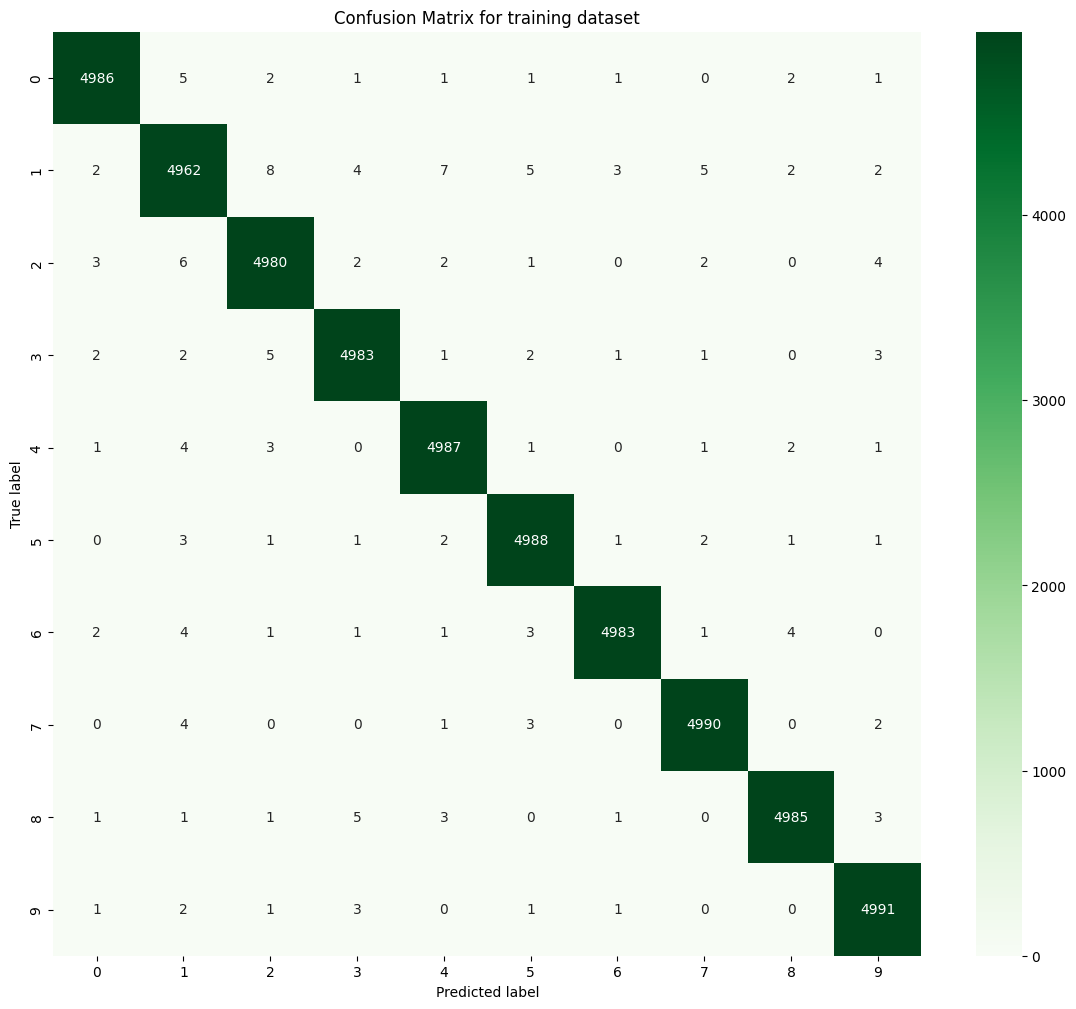

In [39]:
matrix = confusion_matrix(acc_test_ds_y, y_test_acc_pred)

fig, ax = plt.subplots(figsize=(14, 12))
seaborn.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

делаем тестовый предикт и сохраняем:

In [37]:
import pandas as pd
wunderwafel_test = get_bagging_pred(modelset=modelset, x_val=test_ds)

In [38]:
ensemble_model_name = "wunderwafel_ENSY_1"
ans = pd.DataFrame({'Id': np.arange(wunderwafel_test.shape[0]), 'Category': wunderwafel_test})
ans.to_csv(f"../answers/{ensemble_model_name}.csv", index=False)